In [ ]:
function round_odd(N)
   val=Int64(round(N))
    if (val%2)==0     
     if (N-val)>=0
        val+=1
     else
        val-=1
    end
    end
   return val     
end

function round_even(N)
   val=Int64(round(N))
    if (val%2)==1    
     if (N-val)>0
        val+=1
     else
        val-=1 
     end
    end
   return val     
end

In [ ]:
round_odd(600/2)

# Kitaev-Gamma Chain (Arxiv:1910.14304)

## $$\displaystyle \widetilde{H}(\Phi)= \sum_{\; \; \langle i,j \rangle \\ \in \, \gamma  \text{ bond }} -\sin\Phi \;S_{i}^{\gamma} S_{j}^{\gamma}- \cos\Phi\;(S_{i}^{\alpha} S_{j}^{\alpha}+S_{i}^{\beta} S_{j}^{\beta}),$$ 
###  where $\alpha,\beta \neq \gamma$.

## Symmetry Element $\langle ...XXXX...\rangle$ and $\langle \ldots ZZZZ \ldots \rangle$

In [ ]:


using ITensors

function KitaevSymmetryX(T::MPS,start,finish)
    
        mps=copy(T)
        new=copy(T)
        
        for o = (start):1:(finish)
               s = siteind(mps,o)
               newpsi= 2*op(s,"Sx")*mps[o]
               noprime!(newpsi)
               mps[o]= newpsi
        end
            expectation=inner(mps,new)
        return expectation 
end

using ITensors

function KitaevSymmetryZ(T::MPS,start,finish)
    
        mps=copy(T)
        new=copy(T)
        
        for o = (start):1:(finish)
               s = siteind(mps,o)
               newpsi= 2*op(s,"Sz")*mps[o]
               noprime!(newpsi)
               mps[o]= newpsi
        end
        expectation=inner(mps,new)
        return expectation 
end

In [6]:
using ITensors

    N=600
    acc=1E-10
    bond_dim=50
    sites = siteinds("S=1/2",N)
    psi0 = randomMPS(sites,bond_dim)
    D_length=101
    SOPX_odd_bulk=Array{Float64,1}(undef,D_length)
    SOPZ_odd_bulk=Array{Float64,1}(undef,D_length)
    SOPX_even_bulk=Array{Float64,1}(undef,D_length)
    SOPZ_even_bulk=Array{Float64,1}(undef,D_length)
    SOPX_odd_end=Array{Float64,1}(undef,D_length)
    SOPZ_odd_end=Array{Float64,1}(undef,D_length)
    SOPX_even_end=Array{Float64,1}(undef,D_length)
    SOPZ_even_end=Array{Float64,1}(undef,D_length)
    D_store=Array{Float64,1}(undef,D_length)
    sweep=0.15
    phi=-sweep*pi
    cs=cos(phi)
    ss=sin(phi)
    count=0
    
    for D in LinRange(-1, 1, D_length)
        count+=1
        g1=1.0; g2=g1*10.0^D;
        g=Array{Float64,1}(undef,N-1)
        for i=1:length(g)

            if i%2==1
                g[i]=g1;
            else
                g[i]=g2;
            end
        end
        ampo = AutoMPO()
        for j=1:3:N
            ampo += -4*ss*g[j],"Sx",j,"Sx",j+1;
            ampo += -4*cs*g[j],"Sz",j,"Sz",j+1;
            ampo += -4*cs*g[j],"Sy",j,"Sy",j+1;
        end
        for j=2:3:N
            ampo += -4*ss*g[j],"Sz",j,"Sz",j+1;
            ampo += -4*cs*g[j],"Sy",j,"Sy",j+1;
            ampo += -4*cs*g[j],"Sx",j,"Sx",j+1;
        end
        for j=3:3:N-1
            ampo += -4*ss*g[j],"Sy",j,"Sy",j+1;
            ampo += -4*cs*g[j],"Sx",j,"Sx",j+1;
            ampo += -4*cs*g[j],"Sz",j,"Sz",j+1;
        end
        H = MPO(ampo,sites)
        sweeps = Sweeps(15) # number of sweeps is 15
        maxdim!(sweeps,10,20,50,100,200,400,500,600,700) # gradually increase states kept
        cutoff!(sweeps,acc) # desired truncation error
        E0,Kita = dmrg(H,psi0,sweeps,outputlevel=0)#Run the dmrg algorithm
        @show SOPX_odd_end[count]=real(KitaevSymmetryX(Kita,round_even(N/2),N-1))
        @show SOPZ_odd_end[count]=real(KitaevSymmetryZ(Kita,round_even(N/2),N-1))
        @show SOPX_even_end[count]=real(KitaevSymmetryX(Kita,round_odd(N/2),N))
        @show SOPZ_even_end[count]=real(KitaevSymmetryZ(Kita,round_odd(N/2),N))
        SOPX_odd_bulk[count]=real(KitaevSymmetryX(Kita,round_even(N/4),round_odd(3N/4)))
        SOPZ_odd_bulk[count]=real(KitaevSymmetryZ(Kita,round_even(N/4),round_odd(3N/4)))
        SOPX_even_bulk[count]=real(KitaevSymmetryX(Kita,round_odd(N/4),round_even(3N/4)))
        SOPZ_even_bulk[count]=real(KitaevSymmetryZ(Kita,round_odd(N/4),round_even(3N/4)))
        @show D_store[count]= D
    
    end
   
    using DelimitedFiles
        writedlm("x_end_SOPX_bulk_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPX_odd_bulk,',')
        writedlm("x_end_SOPZ_bulk_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPZ_odd_bulk,',')
        writedlm("x_end_SOPX_bulk_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPX_even_bulk,',')
        writedlm("x_end_SOPZ_bulk_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPZ_even_bulk,',')
        writedlm("x_end_SOPX_end_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPX_odd_end,',')
        writedlm("x_end_SOPZ_end_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPZ_odd_end,',')
        writedlm("x_end_SOPX_end_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPX_even_end,',')
        writedlm("x_end_SOPZ_end_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPZ_even_end,',')        

D_store[count] = D = 0.3999999999999999
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9332177180927401
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.922851073885329
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = -2.2131595462469983e-14
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = -1.3810359995689863e-14
D_store[count] = D = 0.41999999999999993
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9399962162027178
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.9303895868169308
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 6.137444965045649e-14
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = -1.308608189179087e-10
D_store[count] = D = 0.43999999999999995
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9460507834247875
SOPZ_

D_store[count] = D = 0.8
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9913368754783036
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.9893607597005127
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 8.204260475152196e-15
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 6.867140947978692e-14
D_store[count] = D = 0.8200000000000001
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9921462246833916
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.9903357176139714
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = -4.076856447630581e-14
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = -1.1610035596478765e-14
D_store[count] = D = 0.8400000000000001
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.992878037565054
SOPZ_odd_end[count] = re

In [ ]:
N=600
sweep=0.15
D_length=101
acc=1E-10
using DelimitedFiles
SOPX_odd_end=readdlm("x_end_SOPX_end_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPZ_odd_end=readdlm("x_end_SOPZ_end_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPX_even_end=readdlm("x_end_SOPX_end_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPZ_even_end=readdlm("x_end_SOPZ_end_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
D_store=LinRange(-1,1,D_length)
SOPX_odd_bulk=readdlm("x_end_SOPX_bulk_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPZ_odd_bulk=readdlm("x_end_SOPZ_bulk_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPX_even_bulk=readdlm("x_end_SOPX_bulk_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPZ_even_bulk=readdlm("x_end_SOPZ_bulk_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')

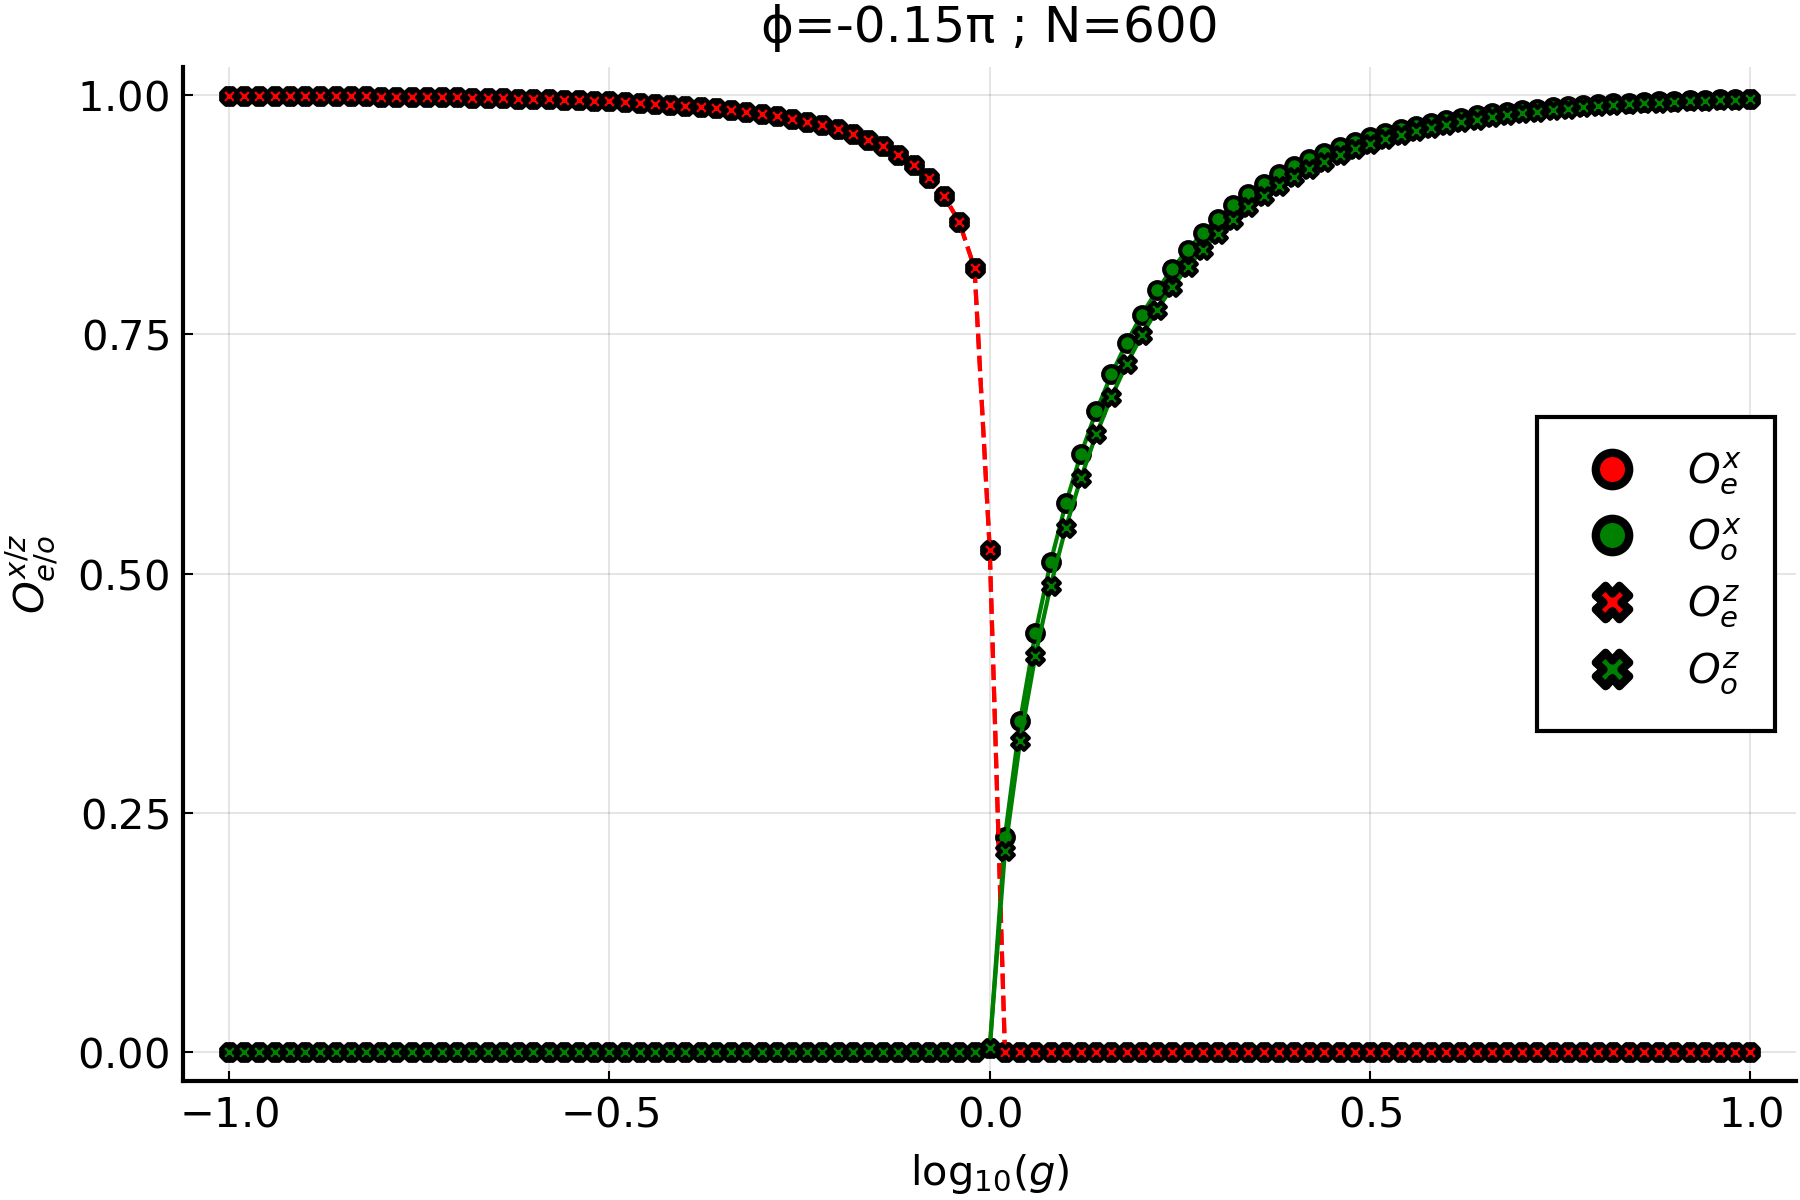

In [8]:
using Plots
using LaTeXStrings
pyplot()
    p1= plot(D_store,SOPX_even_end,title ="ϕ=-0.15π ; N=$N",label=false,legend=:top,fmt = :png,linestyle=:dash,dpi=300,reuse=false,linecolor=:red,xguidefontsize=10,yguidefontsize=10,legendfontsize=10,xtickfontsize=10,ytickfontsize=10,titlefontsize=12) 
    scatter!(D_store,SOPX_even_end,label=L"O_{e}^{x}",legend=:right,dpi=300,markersize=4,reuse=false,markercolor=:red)
    plot!(D_store,SOPX_odd_end,label=false,legend=:top,fmt=:png,linestyle=:solid,dpi=300,reuse=false,linecolor=:green)
    scatter!(D_store,SOPX_odd_end,label=L"O_{o}^{x}",legend=:right,dpi=300,markersize=4,reuse=false,markercolor=:green)
    plot!(D_store,SOPZ_even_end,title ="ϕ=-0.15π ; N=$N",label=false,legend=:top,fmt = :png,linestyle=:dash,dpi=300,reuse=false,linecolor=:red,xguidefontsize=10,yguidefontsize=10,legendfontsize=10,xtickfontsize=10,ytickfontsize=10,titlefontsize=12) 
    scatter!(D_store,SOPZ_even_end,label=L"O_{e}^{z}",legend=:right,dpi=300,markersize=4,markershape=:xcross,reuse=false,markercolor=:red)
    plot!(D_store,SOPZ_odd_end,label=false,legend=:top,fmt=:png,linestyle=:solid,dpi=300,reuse=false,linecolor=:green)
    scatter!(D_store,SOPZ_odd_end,label=L"O_{o}^{z}",legend=:right,dpi=300,markersize=4,markershape=:xcross,reuse=false,markercolor=:green)
    xlabel!(L"\log_{10}(g)")
    ylabel!(L"O_{e/o}^{x/z}")
    #png("x_end_SOPX_DimerisedKG_phi=-$sweep π points=$D_length N=$N accuracy= $acc")

In [ ]:
png("x_end_SOPX_end_DimerisedKG_phi=-$sweep π points=$D_length N=$N accuracy= $acc")

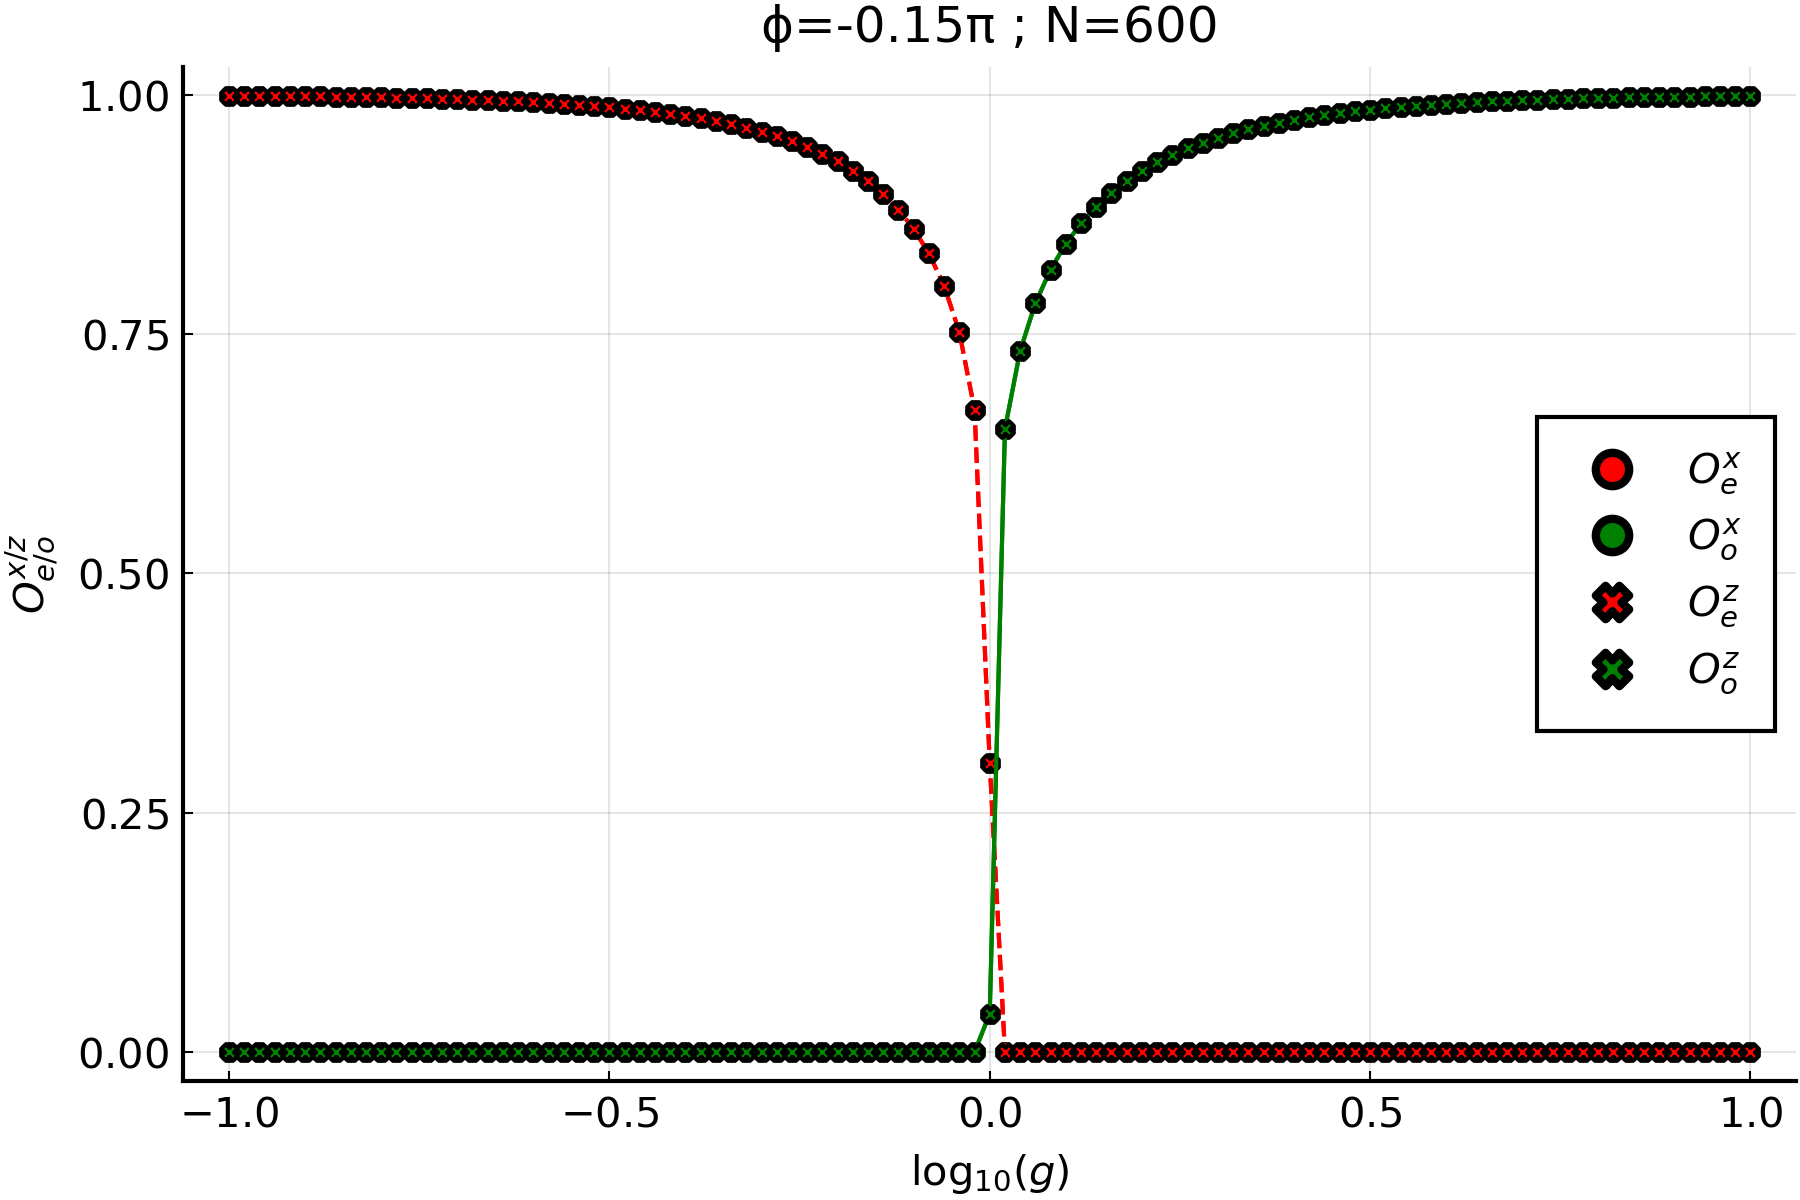

In [10]:
using Plots
using LaTeXStrings
pyplot()
    p1= plot(D_store,SOPX_even_bulk,title ="ϕ=-0.15π ; N=$N",label=false,legend=:top,fmt = :png,linestyle=:dash,dpi=300,reuse=false,linecolor=:red,xguidefontsize=10,yguidefontsize=10,legendfontsize=10,xtickfontsize=10,ytickfontsize=10,titlefontsize=12) 
    scatter!(D_store,SOPX_even_bulk,label=L"O_{e}^{x}",legend=:right,dpi=300,markersize=4,reuse=false,markercolor=:red)
    plot!(D_store,SOPX_odd_bulk,label=false,legend=:top,fmt=:png,linestyle=:solid,dpi=300,reuse=false,linecolor=:green)
    scatter!(D_store,SOPX_odd_bulk,label=L"O_{o}^{x}",legend=:right,dpi=300,markersize=4,reuse=false,markercolor=:green)
    plot!(D_store,SOPZ_even_bulk,title ="ϕ=-0.15π ; N=$N",label=false,legend=:top,fmt = :png,linestyle=:dash,dpi=300,reuse=false,linecolor=:red,xguidefontsize=10,yguidefontsize=10,legendfontsize=10,xtickfontsize=10,ytickfontsize=10,titlefontsize=12) 
    scatter!(D_store,SOPZ_even_bulk,label=L"O_{e}^{z}",legend=:right,dpi=300,markersize=4,markershape=:xcross,reuse=false,markercolor=:red)
    plot!(D_store,abs.(SOPZ_odd_bulk),label=false,legend=:top,fmt=:png,linestyle=:solid,dpi=300,reuse=false,linecolor=:green)
    scatter!(D_store,abs.(SOPZ_odd_bulk),label=L"O_{o}^{z}",legend=:right,dpi=300,markersize=4,markershape=:xcross,reuse=false,markercolor=:green)
    xlabel!(L"\log_{10}(g)")
    ylabel!(L"O_{e/o}^{x/z}")
    #png("y_end_SOPX_DimerisedKG_phi=-$sweep π points=$D_length N=$N accuracy= $acc")

In [ ]:
png("x_end_SOPX_bulk_DimerisedKG_phi=-$sweep π points=$D_length N=$N accuracy= $acc")